In [1]:
import pandas as pd
import numpy as np
import time
import scanpy as sc
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from anndata import AnnData
from anndata.experimental.pytorch import AnnLoader
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import TruncatedSVD

import biomart
import prototypical_network
import helper_fns
import vanilla_vae
from model import PL, Net, train, train_knn, train_logistic_regression

In [2]:
dataset_popv = sc.read("/Volumes/SSD/popv_immune.h5ad")
dataset_celltypist = sc.read("/Volumes/SSD/global.h5ad")
list_celltypes = dataset_popv.obs['cell_type'].unique().tolist()
list_celltypes = list(filter(lambda x: x not in ['myeloid dendritic cell', 'double-positive, alpha-beta thymocyte'], list_celltypes))
dataset_popv = dataset_celltypist[dataset_popv.obs['cell_type'].isin(list_celltypes)]

encoder_celltype = LabelEncoder()
encoder_celltype.fit(dataset_popv.obs['cell_type'])
list_ct = dataset_popv.obs['cell_type'].unique().tolist()
list_num_ct = encoder_celltype.transform(list_ct)
list_inner_nodes = ['popv_immune', 'myeloid leukocyte', 'mature B cell', 'NK', 'CD4', 'CD8']
all_nodes = list_ct + list_inner_nodes

encoder_celltype_inner = LabelEncoder()
encoder_celltype_inner.fit(list_inner_nodes)

g = helper_fns.build_hierarchical_tree_popv_immune(all_nodes=all_nodes, list_ct=list_ct, list_inner_nodes=list_inner_nodes, encoder_celltype=encoder_celltype, encoder_celltype_inner=encoder_celltype_inner)

dist_df = helper_fns.get_dist_df(list_num_ct=list_num_ct, g=g)
D = torch.tensor(dist_df.values, dtype=float)
ensembl_to_genesymbol = helper_fns.get_ensembl_mappings()

genes_celltypist = dataset_celltypist.var_names
genes_popv = dataset_popv.var_names
not_found = []
found_hgnc = []
found_ensembl = []
for i in range(len(list(genes_celltypist))):
    try:
        a = ensembl_to_genesymbol[genes_celltypist[i]]
        if a not in genes_popv:
            not_found.append(genes_celltypist[i])
        else:
            found_hgnc.append(genes_celltypist[i])
            found_ensembl.append(a)
    except KeyError:
        not_found.append(genes_celltypist[i])

# filter the anndata by the found_ensembl genes
dataset_popv = dataset_popv[:,found_ensembl]
dataset_celltypist = dataset_celltypist[:,found_hgnc]

train_indices, test_indices, cv = helper_fns.costumized_train_test_split(dataset_popv, cross_validation=False, k_fold=5, obs_key='cell_type')
sc.pp.normalize_total(dataset_popv, 1e4)
sc.pp.log1p(dataset_popv)
sc.pp.highly_variable_genes(dataset_popv)
highly_variable_genes = dataset_popv.var['highly_variable']
dataset_popv = dataset_popv[:,highly_variable_genes]
pca = TruncatedSVD(n_components=128)
pca.fit(dataset_popv[train_indices].X)
dataset_popv_pca = AnnData(pca.transform(dataset_popv.X))
dataset_popv_pca.obs = dataset_popv.obs

train_subsampler = torch.utils.data.SubsetRandomSampler(train_indices)
test_subsampler = torch.utils.data.SubsetRandomSampler(test_indices)

# Define data loaders for training and testing data in this fold
encoders = {
    'obs': {
        'cell_type': encoder_celltype.transform
    }
}
dataloader_training = AnnLoader(dataset_popv_pca, batch_size=512, convert=encoders, sampler=train_subsampler)
dataloader_testing = AnnLoader(dataset_popv_pca, batch_size=512, convert=encoders, sampler=test_subsampler)


# Label encoder // No problem
encoder_celltype_celltypist = LabelEncoder()
encoder_celltype_celltypist.fit(dataset_celltypist.obs['Manually_curated_celltype'])

sc.pp.normalize_total(dataset_celltypist, 1e4)
sc.pp.log1p(dataset_celltypist)
dataset_celltypist = dataset_celltypist[:,highly_variable_genes]
dataset_celltypist_pca = AnnData(pca.transform(dataset_celltypist.X))
dataset_celltypist_pca.obs = dataset_celltypist.obs

/Users/xbh0403/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/xbh0403/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


/Users/xbh0403/Desktop/HCell/model.py:88: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:204.)
  centers = torch.tensor(centers, dtype=float)


Epoch 1
Train ER 59.51, time 7.2s
Test ER 51.30, time 0.6s
Epoch 2
Train ER 48.75, time 6.7s
Test ER 46.46, time 0.6s
Epoch 3
Train ER 46.16, time 6.7s
Test ER 46.06, time 0.7s
Epoch 4
Train ER 44.26, time 6.7s
Test ER 43.26, time 0.7s
Epoch 5
Train ER 42.90, time 6.7s
Test ER 42.07, time 0.6s
Epoch 6
Train ER 41.44, time 6.7s
Test ER 40.98, time 0.6s
Epoch 7
Train ER 40.57, time 6.7s
Test ER 41.66, time 0.6s
Epoch 8
Train ER 39.29, time 6.7s
Test ER 38.82, time 0.6s
Epoch 9
Train ER 38.12, time 6.6s
Test ER 39.58, time 0.7s
Epoch 10
Train ER 37.26, time 6.6s
Test ER 36.68, time 0.7s
Epoch 11
Train ER 36.25, time 6.7s
Test ER 36.23, time 0.6s
Epoch 12
Train ER 35.37, time 6.7s
Test ER 35.46, time 0.6s
Epoch 13
Train ER 34.94, time 6.7s
Test ER 34.91, time 0.6s
Epoch 14
Train ER 34.09, time 6.7s
Test ER 34.15, time 0.6s
Epoch 15
Train ER 33.64, time 6.6s
Test ER 33.62, time 0.7s
Epoch 16
Train ER 33.03, time 6.6s
Test ER 33.05, time 0.7s
Epoch 17
Train ER 32.62, time 6.7s
Test ER 32.80,

/Users/xbh0403/Desktop/HCell/helper_fns.py:305: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


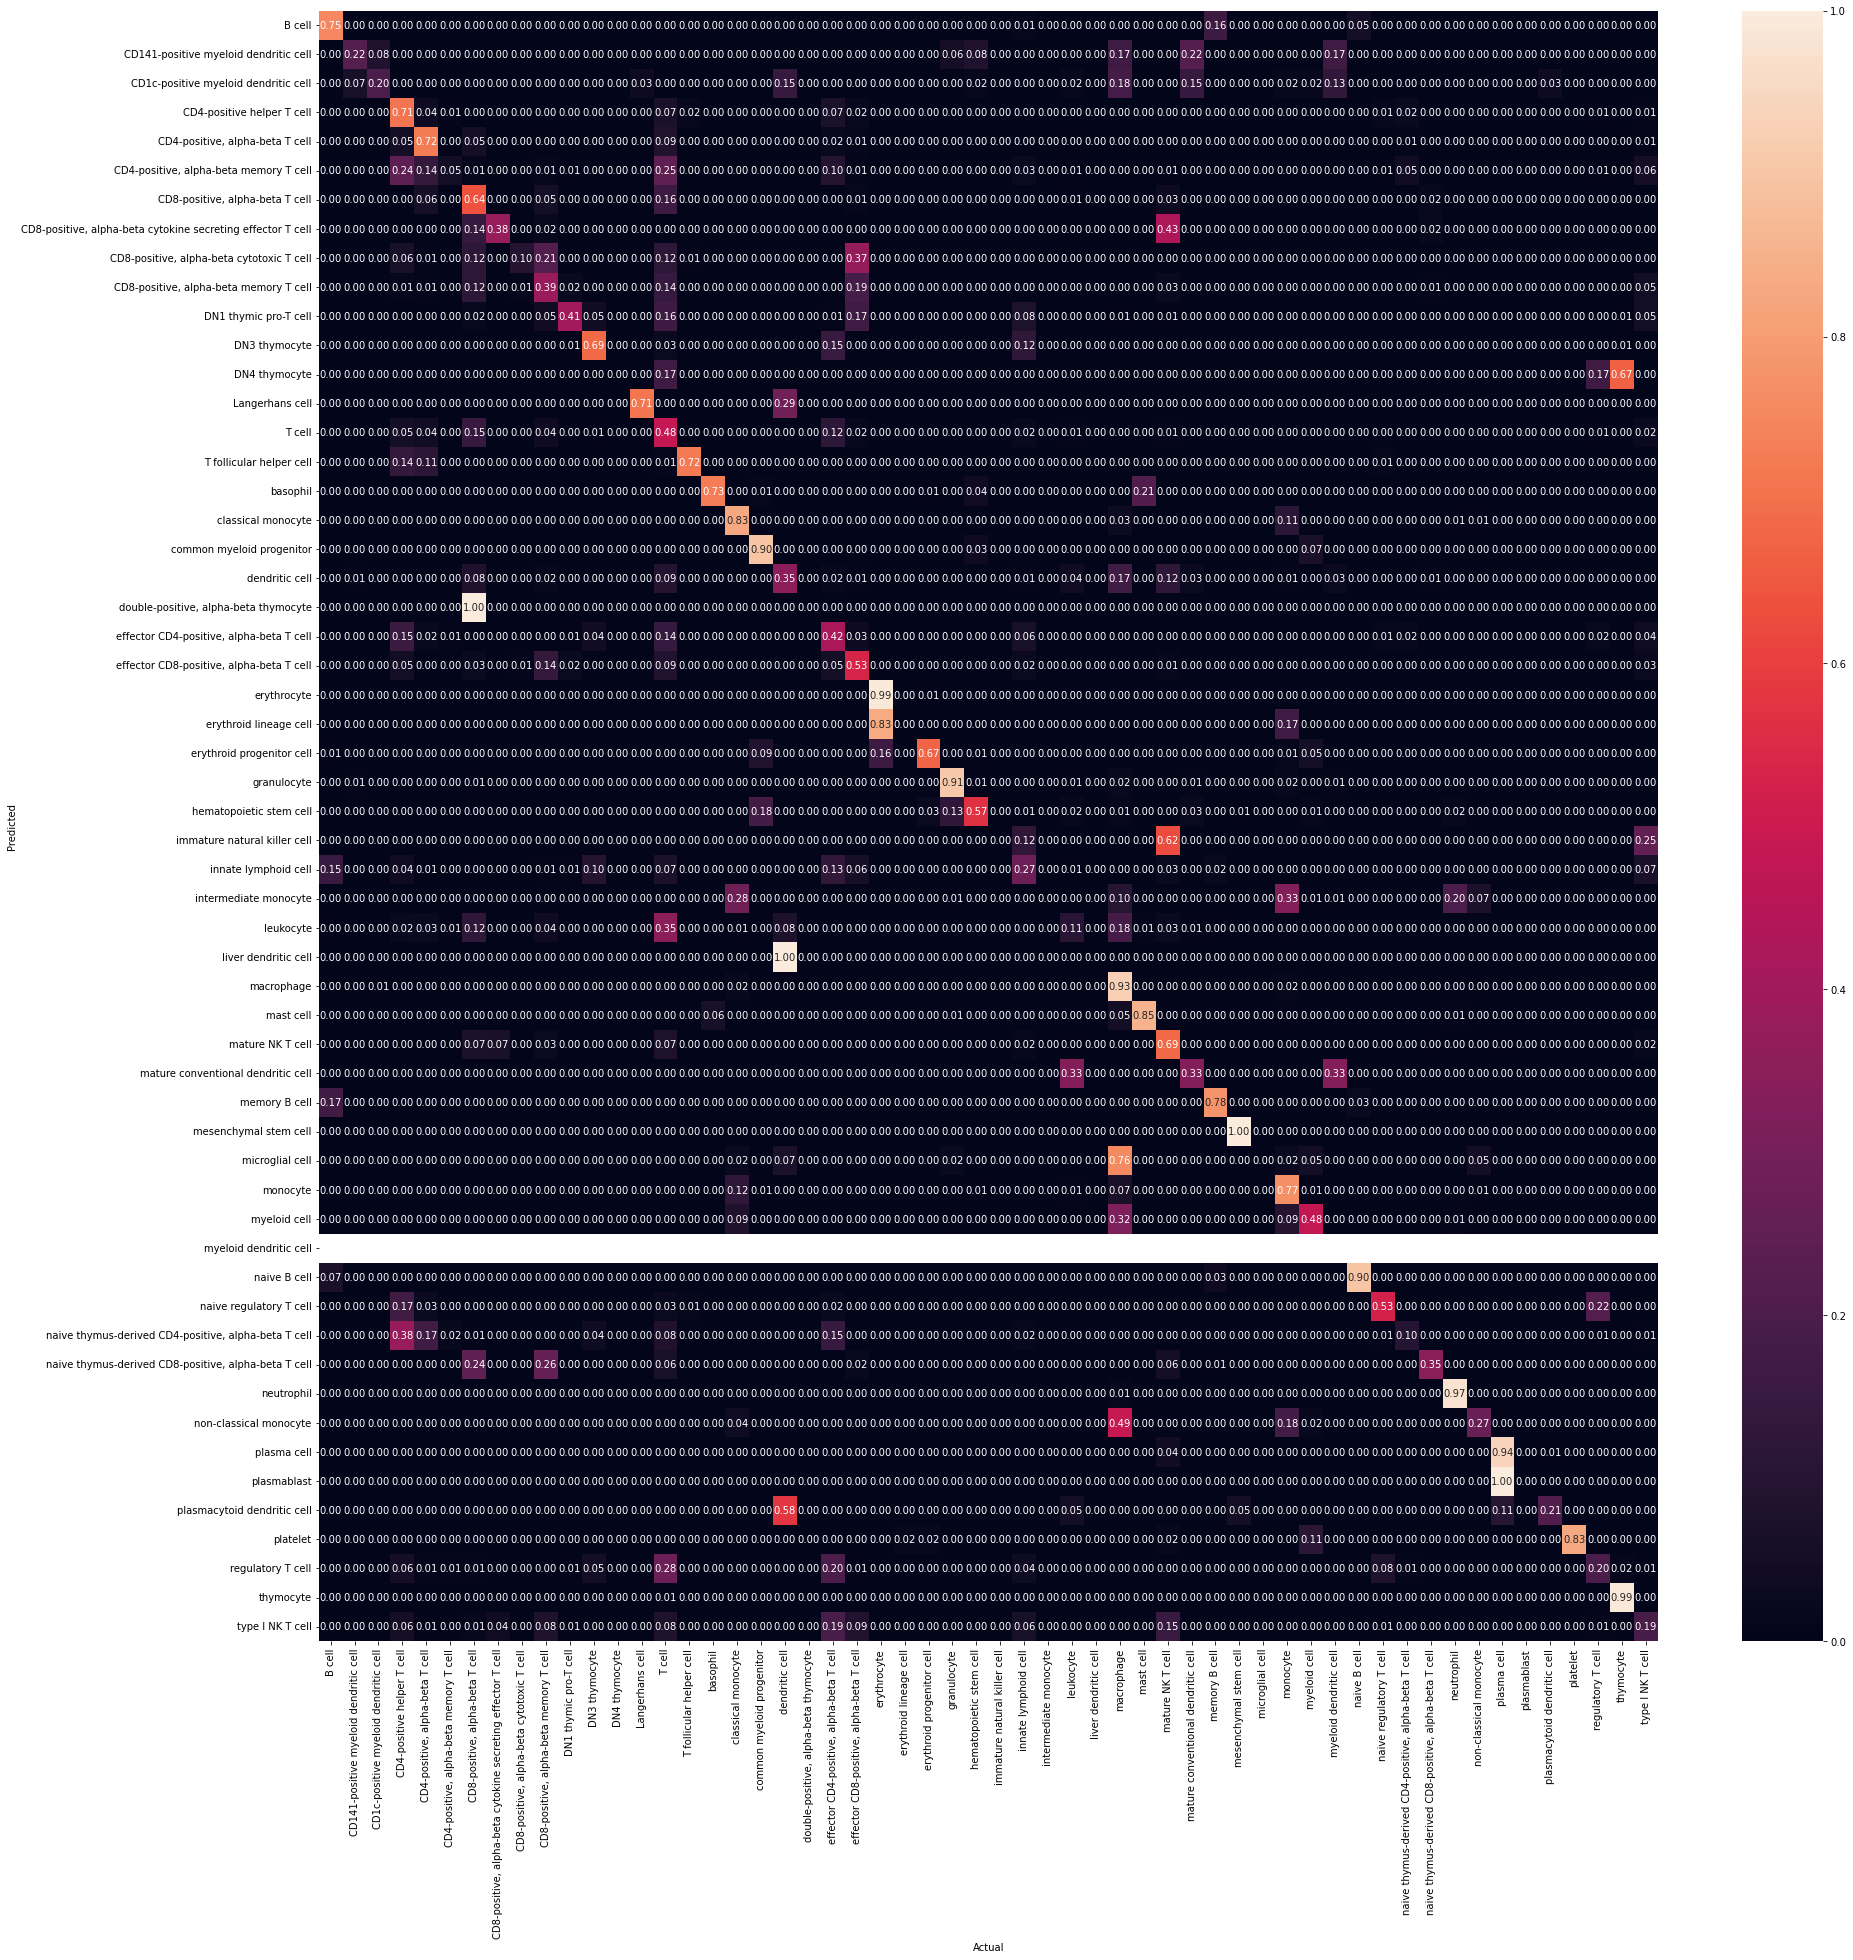

In [3]:
weights = helper_fns.get_weights(num_celltypes=len(list_num_ct), dataset=dataset_popv_pca, encoder=encoder_celltype, obs='cell_type')
model = train(mode='Proto_Net', loss_mode='disto_pl', epochs=50, embedding_dim=16, D=D, num_celltypes=list_num_ct, 
    encoder=encoder_celltype, dataset=dataset_popv_pca, dataloader_training=dataloader_training, dataloader_testing=dataloader_testing, 
    obs_name='cell_type', init_weights=weights)
embedding_prototypes, embedding_prototypes_labels = helper_fns.get_prototypes_and_labels(model=model, encoder=encoder_celltype, num_celltypes=len(list_num_ct))
helper_fns.plot_confusion_matrix('Proto_Net', model, dataset=dataset_popv_pca, encoder=encoder_celltype, test_indices=test_indices, obs_name='cell_type')

In [4]:
model_logistic = train_logistic_regression(dataset=dataset_popv_pca, train_indices=train_indices, test_indices=test_indices, encoder=encoder_celltype, obs_name='cell_type')
model_knn = train_knn(dataset=dataset_popv_pca, train_indices=train_indices, test_indices=test_indices, encoder=encoder_celltype, obs_name='cell_type')

/Users/xbh0403/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression
Train error: 27.552811915954013%
Test error: 28.549301095579903%
kNN
Train error: 18.305771082290313%
Test error: 26.152247827729504%


In [5]:
test_celltypes = ['Memory B cells', 'Naive B cells', 'Tfh', 'Plasma cells', 'Tregs']
train_celltypes = ['memory B cell', 'naive B cell', 'T follicular helper cell', 'plasma cell', 'regulatory T cell']

In [6]:
train_embeddings, training_preds = helper_fns.get_embeddings_and_out(model, dataset_popv_pca[train_indices], encoder=encoder_celltype)
test_embeddings, test_preds = helper_fns.get_embeddings_and_out(model, dataset_celltypist_pca, encoder=encoder_celltype)
prototypes, prototypes_labels = helper_fns.get_prototypes_and_labels(model, encoder=encoder_celltype, num_celltypes=len(list_num_ct))

In [7]:
# helper_fns.plot_embeddings_given_labels_and_datasets(train_embeddings=train_embeddings, test_embeddings=test_embeddings,
#  train_true_labels=dataset_celltypist_pca[train_indices].obs['Manually_curated_celltype'], test_true_labels=dataset_popv_pca.obs['cell_type'],
#  test_pred_labels=test_preds, train_celltype='Memory B cells', test_celltype='memory B cell', prototypes=prototypes, prototypes_labels=prototypes_labels)

In [8]:
# helper_fns.plot_embeddings_given_labels_and_datasets(train_embeddings=train_embeddings, test_embeddings=test_embeddings,
#  train_true_labels=dataset_celltypist_pca[train_indices].obs['Manually_curated_celltype'], test_true_labels=dataset_popv_pca.obs['cell_type'],
#  test_pred_labels=test_preds, train_celltype='Naive B cells', test_celltype='naive B cell', prototypes=prototypes, prototypes_labels=prototypes_labels)

In [9]:
# helper_fns.plot_embeddings_given_labels_and_datasets(train_embeddings=train_embeddings, test_embeddings=test_embeddings,
#  train_true_labels=dataset_celltypist_pca[train_indices].obs['Manually_curated_celltype'], test_true_labels=dataset_popv_pca.obs['cell_type'],
#  test_pred_labels=test_preds, train_celltype='Tfh', test_celltype='T follicular helper cell', prototypes=prototypes, prototypes_labels=prototypes_labels)

In [10]:
# helper_fns.plot_embeddings_given_labels_and_datasets(train_embeddings=train_embeddings, test_embeddings=test_embeddings,
#  train_true_labels=dataset_celltypist_pca[train_indices].obs['Manually_curated_celltype'], test_true_labels=dataset_popv_pca.obs['cell_type'],
#  test_pred_labels=test_preds, train_celltype='Plasma cells', test_celltype='plasma cell', prototypes=prototypes, prototypes_labels=prototypes_labels)

In [11]:
# helper_fns.plot_embeddings_given_labels_and_datasets(train_embeddings=train_embeddings, test_embeddings=test_embeddings,
#  train_true_labels=dataset_celltypist_pca[train_indices].obs['Manually_curated_celltype'], test_true_labels=dataset_popv_pca.obs['cell_type'],
#  test_pred_labels=test_preds, train_celltype='Tregs', test_celltype='regulatory T cell', prototypes=prototypes, prototypes_labels=prototypes_labels)

In [12]:
# helper_fns.plot_embeddings_scatter(embeddings=test_embeddings, true_labels=dataset_popv_pca.obs['cell_type'], 
#     embedding_prototypes=prototypes, embedding_prototypes_labels=prototypes_labels)

In [13]:
# helper_fns.plot_embeddings_scatter(embeddings=train_embeddings, true_labels=dataset_celltypist_pca[train_indices].obs['Manually_curated_celltype'], 
#     embedding_prototypes=prototypes, embedding_prototypes_labels=prototypes_labels)

In [14]:
# helper_fns.plot_embeddings_scatter(embeddings=test_embeddings, true_labels=dataset_celltypist_pca[test_indices].obs['Manually_curated_celltype'], 
#     embedding_prototypes=prototypes, embedding_prototypes_labels=prototypes_labels)

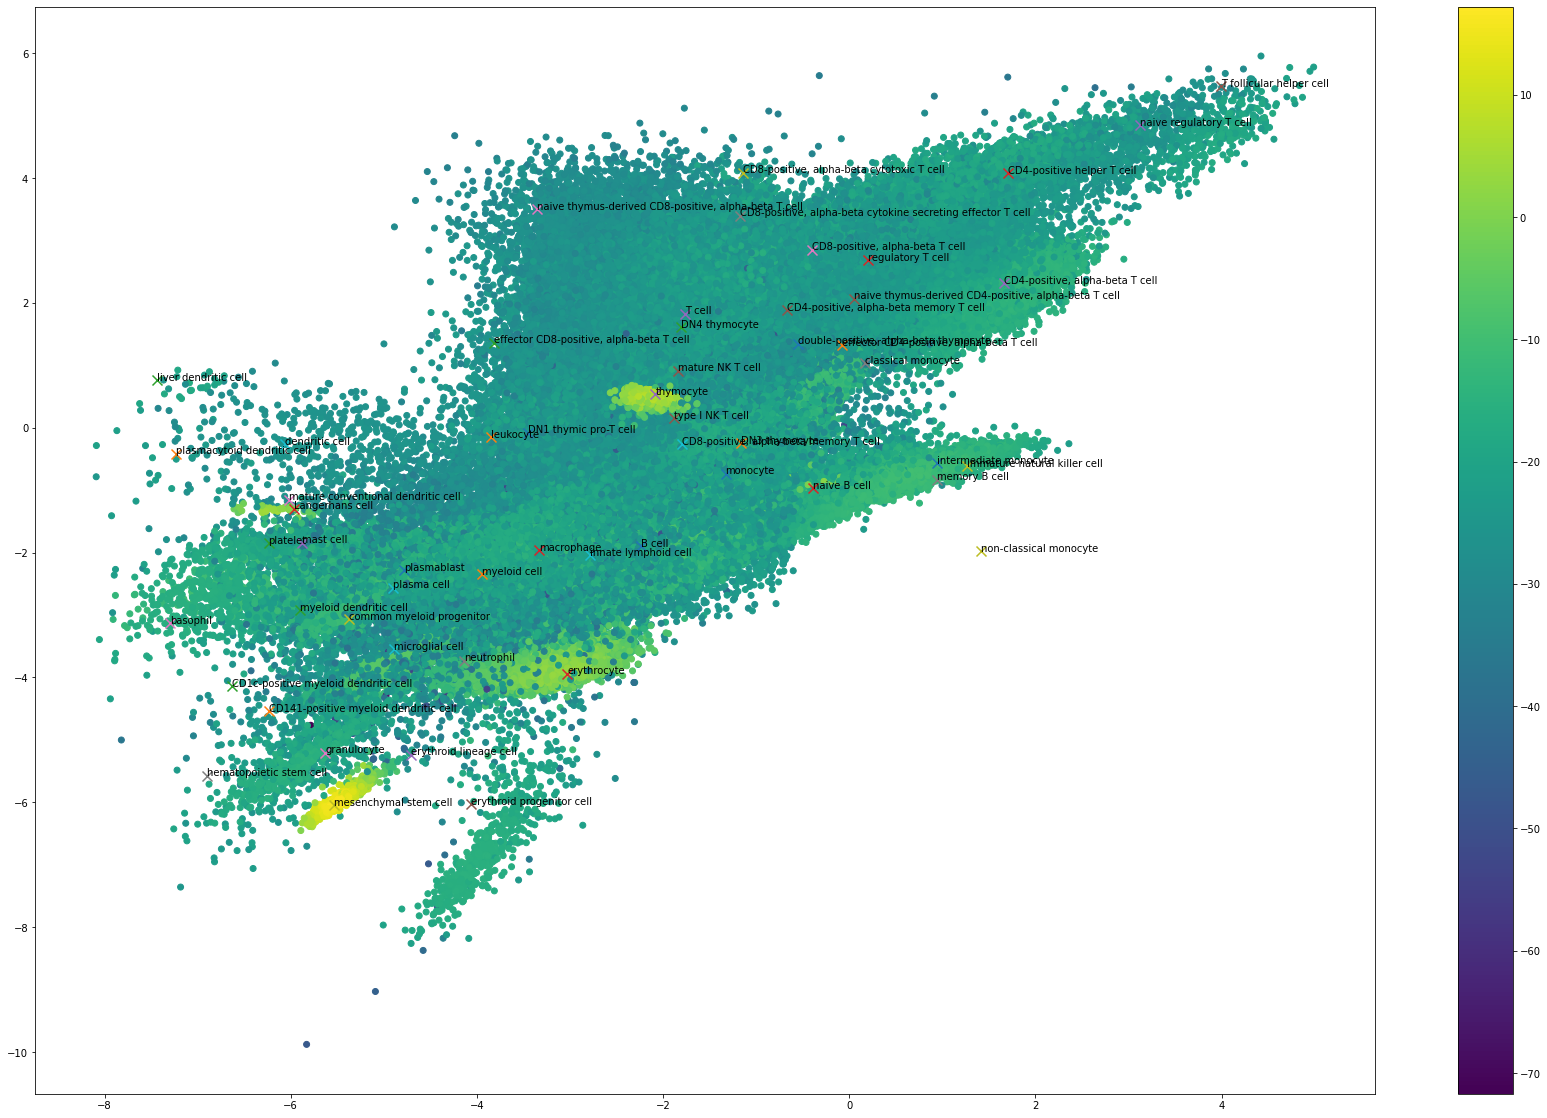

In [15]:
helper_fns.plot_embeddings_likelihood(model=model, encoder=encoder_celltype, pred_labels=training_preds, 
    embeddings=train_embeddings, prototypes=prototypes, prototypes_labels=prototypes_labels)

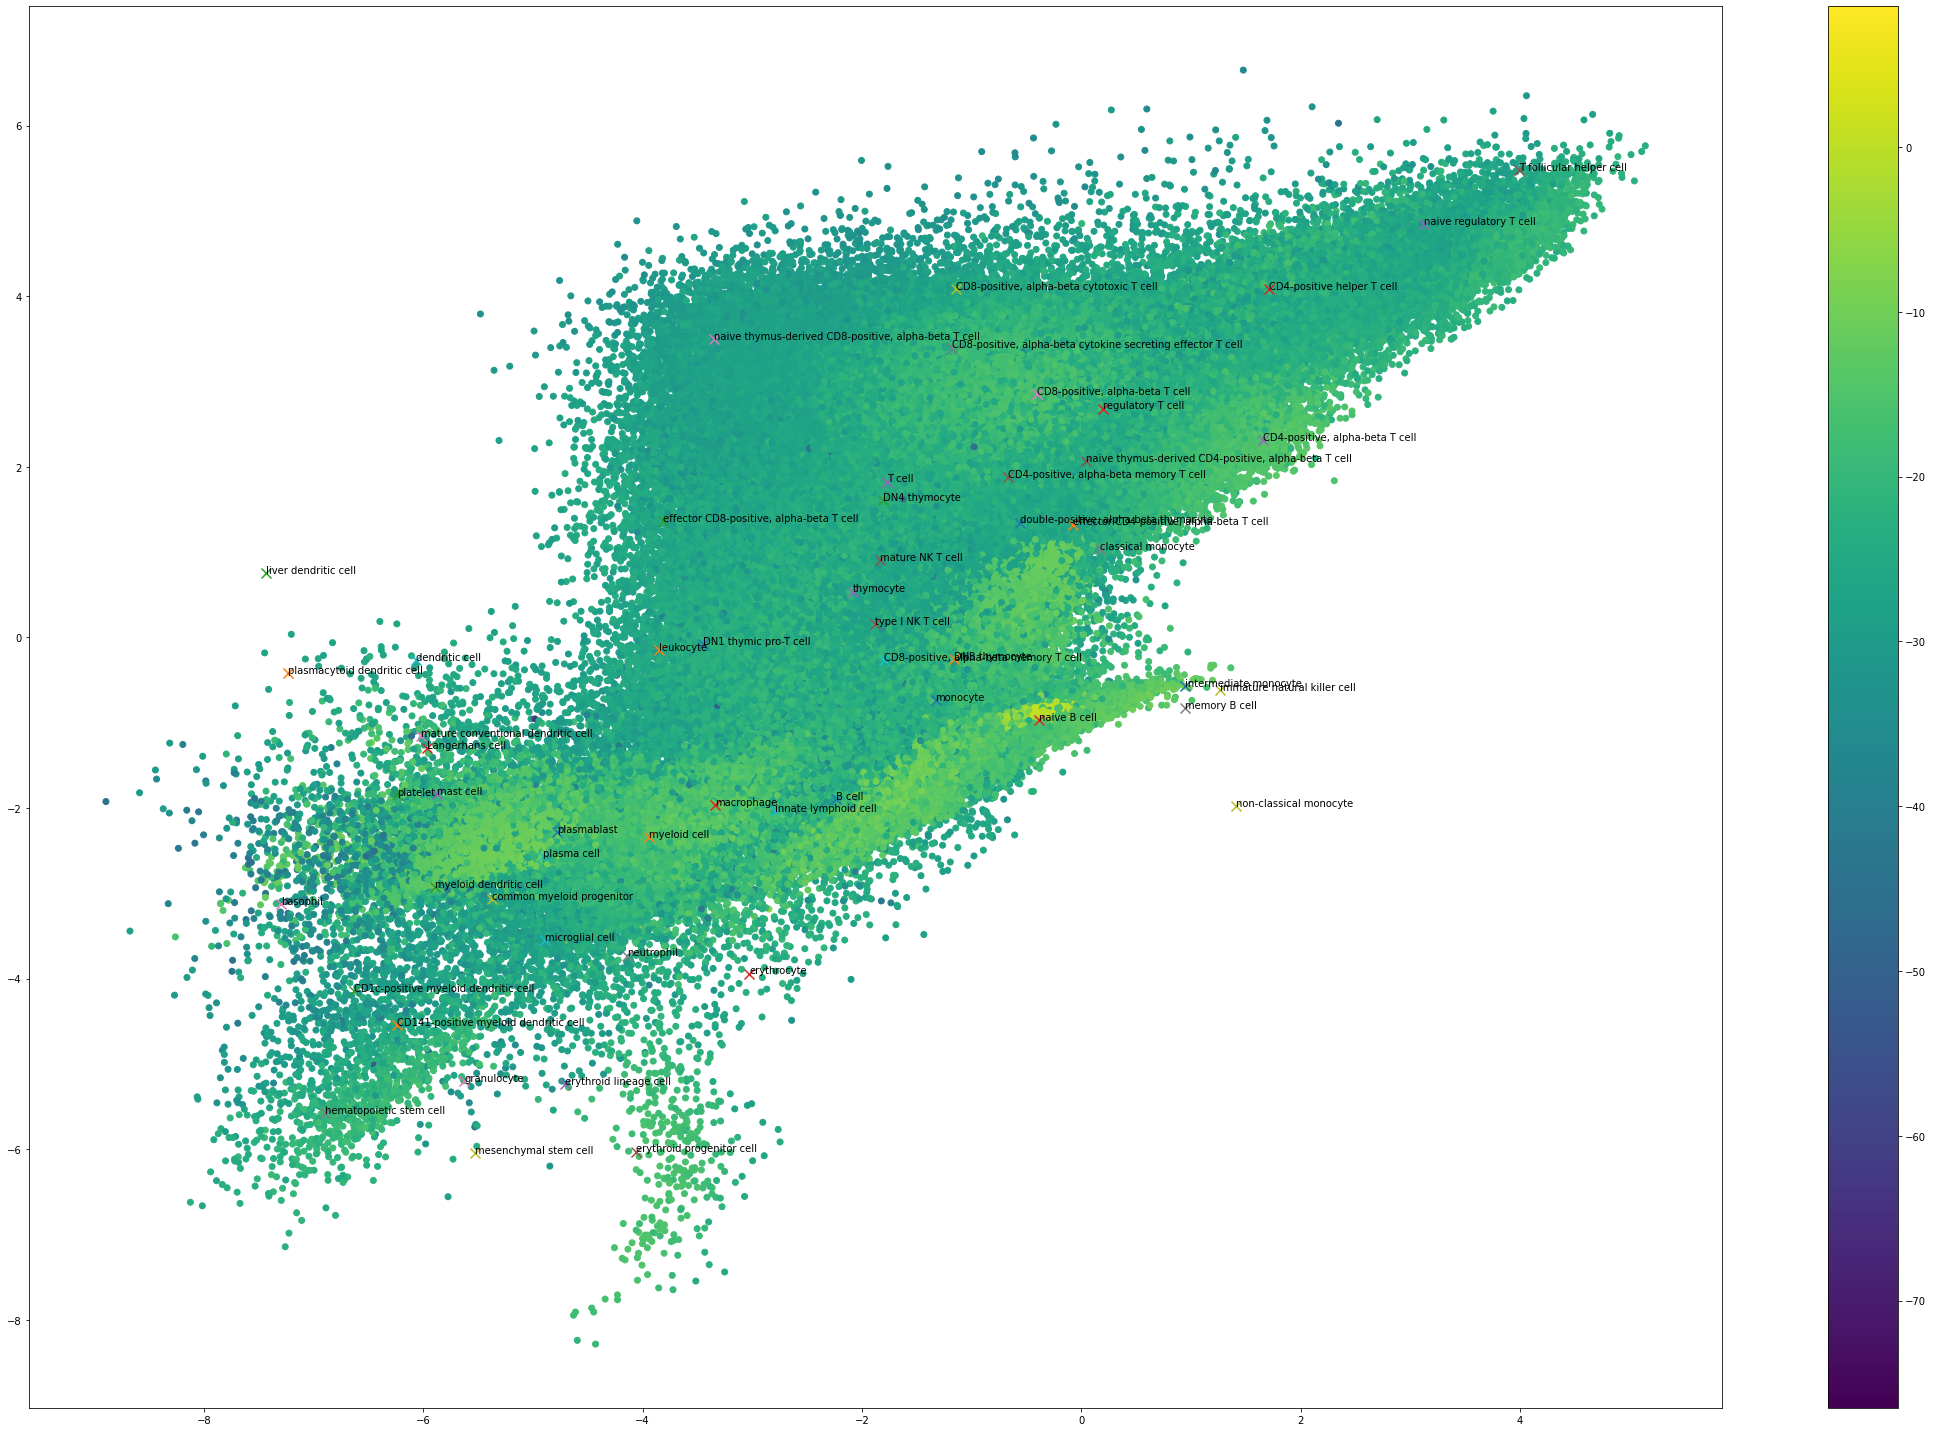

In [16]:
helper_fns.plot_embeddings_likelihood(model=model, encoder=encoder_celltype, pred_labels=test_preds, 
    embeddings=test_embeddings, prototypes=prototypes, prototypes_labels=prototypes_labels)

In [17]:
print("OUR MODEL")
for i in range(len(train_celltypes)):
    print('\n')
    helper_fns.print_true_positive_given_labels_and_datasets(test_true_labels=dataset_celltypist_pca.obs['Manually_curated_celltype'], test_pred_labels=test_preds, 
        train_celltype=train_celltypes[i], test_celltype=test_celltypes[i])

print('\n')
print("Logistic Regression")
test_preds_logistic = encoder_celltype.inverse_transform(model_logistic.predict(dataset_celltypist_pca.X))
for i in range(len(train_celltypes)):
    print('\n')
    helper_fns.print_true_positive_given_labels_and_datasets(test_true_labels=dataset_celltypist_pca.obs['Manually_curated_celltype'], test_pred_labels=test_preds_logistic, 
        train_celltype=train_celltypes[i], test_celltype=test_celltypes[i])

print('\n')
print("kNN")
test_preds_knn = encoder_celltype.inverse_transform(model_knn.predict(dataset_celltypist_pca.X))
for i in range(len(train_celltypes)):
    print('\n')
    helper_fns.print_true_positive_given_labels_and_datasets(test_true_labels=dataset_celltypist_pca.obs['Manually_curated_celltype'], test_pred_labels=test_preds_knn, 
        train_celltype=train_celltypes[i], test_celltype=test_celltypes[i])

OUR MODEL


True positive Memory B cells: 6.678194708628739%
{'B cell': 26743, 'innate lymphoid cell': 80, 'T cell': 26, 'naive B cell': 87, 'plasma cell': 11, 'leukocyte': 23, 'monocyte': 1, 'CD4-positive, alpha-beta T cell': 7, 'mature conventional dendritic cell': 2, 'macrophage': 3, 'dendritic cell': 1}


True positive Naive B cells: 24.37491070152879%
{'B cell': 10352, 'T cell': 1, 'memory B cell': 220, 'platelet': 1, 'plasma cell': 3, 'dendritic cell': 1, 'leukocyte': 5, 'macrophage': 1, 'hematopoietic stem cell': 1, 'innate lymphoid cell': 1}


True positive Tfh: 2.236317269338913%
{'effector CD4-positive, alpha-beta T cell': 6685, 'T cell': 2971, 'CD4-positive helper T cell': 2008, 'DN3 thymocyte': 93, 'CD4-positive, alpha-beta T cell': 1257, 'effector CD8-positive, alpha-beta T cell': 142, 'thymocyte': 51, 'type I NK T cell': 642, 'CD4-positive, alpha-beta memory T cell': 122, 'naive regulatory T cell': 13, 'CD8-positive, alpha-beta T cell': 45, 'leukocyte': 4, 'regulatory T c